# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000,
                     num_validation=1000,
                     num_test=1000,
                     num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.324337
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** When weights are all initialised like this, small and nearly equal, the term $$\frac{e^{s_i}}{\sum{e^{s_j}}}$$ will be close to $$\frac{1}{num\_classes}$$ which is 0.1.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.037385 analytic: 1.037385, relative error: 2.452013e-08
numerical: 0.220925 analytic: 0.220925, relative error: 4.573524e-08
numerical: 1.765354 analytic: 1.765354, relative error: 1.191920e-08
numerical: -0.099995 analytic: -0.099995, relative error: 1.627994e-08
numerical: -1.427544 analytic: -1.427544, relative error: 6.038597e-09
numerical: -1.152039 analytic: -1.152039, relative error: 3.262598e-08
numerical: 0.357135 analytic: 0.357135, relative error: 1.961145e-07
numerical: -2.757082 analytic: -2.757082, relative error: 2.016733e-08
numerical: 1.924336 analytic: 1.924336, relative error: 2.056000e-08
numerical: 2.790824 analytic: 2.790824, relative error: 7.624874e-09
numerical: 1.526463 analytic: 1.526463, relative error: 3.469084e-08
numerical: -0.697966 analytic: -0.697966, relative error: 8.645856e-08
numerical: -1.541791 analytic: -1.541791, relative error: 2.677391e-08
numerical: 0.583536 analytic: 0.583535, relative error: 2.935246e-08
numerical: -0.732863 a

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.324337e+00 computed in 0.200260s
vectorized loss: 2.324337e+00 computed in 0.007761s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-6]
regularization_strengths = [1e2, 1e6]

for _ in np.arange(50):
    i = 10 ** np.random.uniform(low=np.log10(learning_rates[0]), high=np.log10(learning_rates[1]))
    j = 10 ** np.random.uniform(low=np.log10(regularization_strengths[0]), high=np.log10(regularization_strengths[1]))
    
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=i, reg=j, 
                  num_iters=500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    accuracy = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
    
    results[(i, j)] = accuracy
    
    if accuracy[1] > best_val:
        best_val = accuracy[1]
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.082118e-07 reg 3.305278e+03 train accuracy: 0.217939 val accuracy: 0.204000
lr 1.106113e-07 reg 3.962761e+03 train accuracy: 0.223347 val accuracy: 0.216000
lr 1.148284e-07 reg 1.000276e+05 train accuracy: 0.308286 val accuracy: 0.326000
lr 1.169507e-07 reg 1.119909e+04 train accuracy: 0.243857 val accuracy: 0.262000
lr 1.175542e-07 reg 1.314417e+05 train accuracy: 0.302408 val accuracy: 0.315000
lr 1.202655e-07 reg 3.565040e+04 train accuracy: 0.310245 val accuracy: 0.318000
lr 1.231750e-07 reg 3.055957e+03 train accuracy: 0.207551 val accuracy: 0.215000
lr 1.245393e-07 reg 1.039571e+05 train accuracy: 0.307796 val accuracy: 0.326000
lr 1.309097e-07 reg 7.216126e+04 train accuracy: 0.320510 val accuracy: 0.328000
lr 1.332408e-07 reg 9.789596e+02 train accuracy: 0.218612 val accuracy: 0.207000
lr 1.401429e-07 reg 3.397788e+03 train accuracy: 0.220755 val accuracy: 0.241000
lr 1.577227e-07 reg 1.123149e+04 train accuracy: 0.269592 val accuracy: 0.274000
lr 1.681815e-07 reg 3.247425

In [11]:
# Get the best hyperparameter from result
best_lr = 0.0
best_reg = 0.0

for lr, reg in results:
    if results[(lr, reg)][1] == best_val:
        best_lr = lr
        best_reg = reg
        break
        
print 'Best learning rate: %f, best regularisation strength: %f' % (best_lr, best_reg, )

Best learning rate: 0.000001, best regularisation strength: 8168.232289


iteration 0 / 2000: loss 131.438999
iteration 100 / 2000: loss 43.975306
iteration 200 / 2000: loss 15.983530
iteration 300 / 2000: loss 6.604651
iteration 400 / 2000: loss 3.533450
iteration 500 / 2000: loss 2.417838
iteration 600 / 2000: loss 2.069714
iteration 700 / 2000: loss 2.004260
iteration 800 / 2000: loss 1.908515
iteration 900 / 2000: loss 1.875429
iteration 1000 / 2000: loss 1.849189
iteration 1100 / 2000: loss 1.906478
iteration 1200 / 2000: loss 1.957726
iteration 1300 / 2000: loss 1.851659
iteration 1400 / 2000: loss 1.942394
iteration 1500 / 2000: loss 1.879821
iteration 1600 / 2000: loss 1.925220
iteration 1700 / 2000: loss 1.931358
iteration 1800 / 2000: loss 2.024928
iteration 1900 / 2000: loss 1.961868


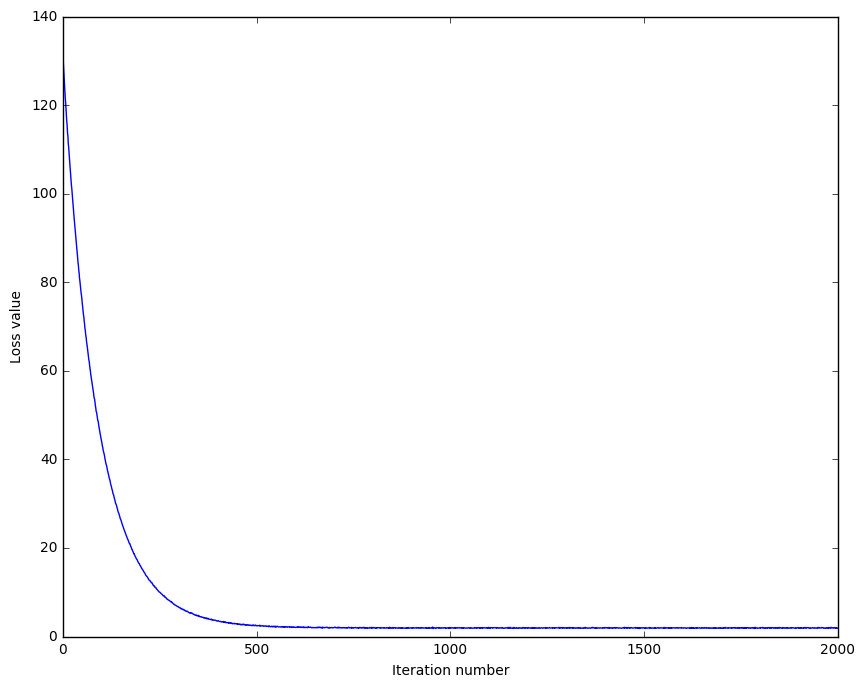

In [14]:
# Train the classifier with the best hyperparameters
best_softmax = Softmax()
loss_hist = best_softmax.train(X_train, y_train, learning_rate=best_lr, reg=best_reg, 
                  num_iters=2000, verbose=True)

# plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.368000


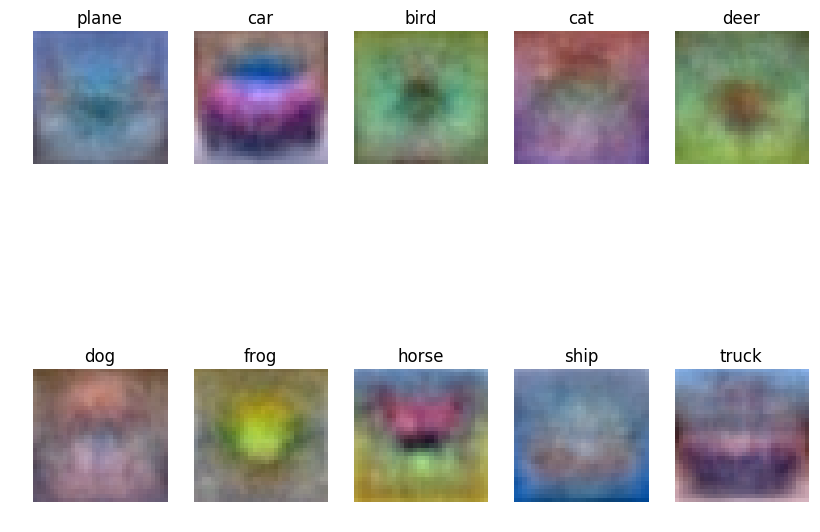

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1, :]  # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
    'truck'
]
for i in xrange(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

The visualised weights are again an image representation of the percieved average image of each class.